Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [30]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from scipy import stats
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import random
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import cross_val_score

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'http://commondatastorage.googleapis.com/books1000/'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [5]:
def display_image(folder):
    """Displays a random image for each of the sub-folders A-J"""
    files = os.listdir(folder)
    rand_file_idx = random.randrange(0, len(files)-1)
    print("Selected file %s amongst %s files in subfolder %s" % (rand_file_idx, str(len(files)), folder))
    rand_file = files[rand_file_idx]
    rand_file_type = rand_file[rand_file.rfind('.')+1:]
    rand_file_path = os.path.join(folder, rand_file)
    display(Image(filename=rand_file_path, format=rand_file_type))

for f in train_folders:
    display_image(f)    

Selected file 39265 amongst 52912 files in subfolder notMNIST_large/A


Selected file 37214 amongst 52912 files in subfolder notMNIST_large/B


Selected file 2169 amongst 52912 files in subfolder notMNIST_large/C


Selected file 33179 amongst 52912 files in subfolder notMNIST_large/D


Selected file 41331 amongst 52912 files in subfolder notMNIST_large/E


Selected file 32724 amongst 52912 files in subfolder notMNIST_large/F


Selected file 32573 amongst 52912 files in subfolder notMNIST_large/G


Selected file 25235 amongst 52912 files in subfolder notMNIST_large/H


Selected file 50380 amongst 52912 files in subfolder notMNIST_large/I


Selected file 45959 amongst 52911 files in subfolder notMNIST_large/J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  image_index = 0
  print(folder)
  for image in os.listdir(folder):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file - it's ok, skipping.
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.128482
Standard deviation: 0.425621
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756895
Standard deviation: 0.417204
Pickling notMNIST_large/C.pickle.
notMNIST_large/C
Full dataset tensor: (52912, 28, 28)
Mean: -0.142338
Standard deviation: 0.421339
Pickling notMNIST_large/D.pickle.
notMNIST_large/D
Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cann

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

Displaying image 39057 of 52909 from pickle file notMNIST_large/A.pickle


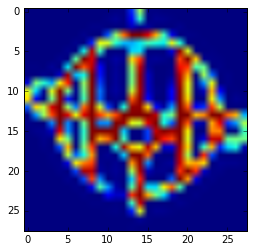

Displaying image 6051 of 52911 from pickle file notMNIST_large/B.pickle


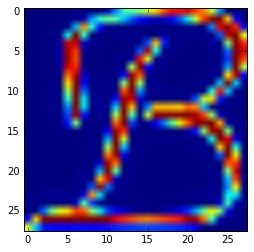

Displaying image 21182 of 52912 from pickle file notMNIST_large/C.pickle


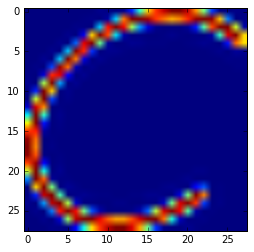

Displaying image 29897 of 52911 from pickle file notMNIST_large/D.pickle


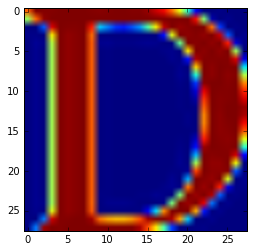

Displaying image 36391 of 52912 from pickle file notMNIST_large/E.pickle


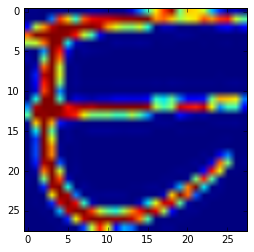

Displaying image 45400 of 52912 from pickle file notMNIST_large/F.pickle


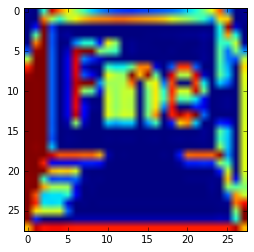

Displaying image 14928 of 52912 from pickle file notMNIST_large/G.pickle


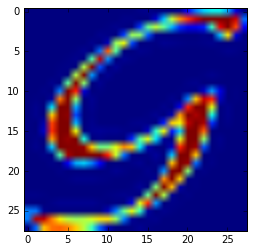

Displaying image 26830 of 52912 from pickle file notMNIST_large/H.pickle


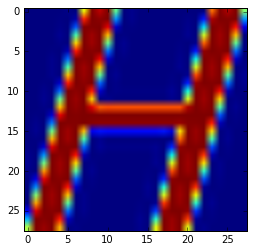

Displaying image 13815 of 52912 from pickle file notMNIST_large/I.pickle


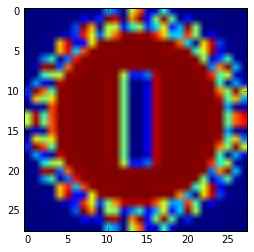

Displaying image 26455 of 52911 from pickle file notMNIST_large/J.pickle


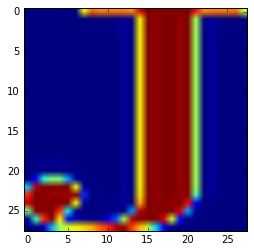

In [7]:
def display_pickle_image(pickle_file=None, image_arr=None):
    """Display random resampled image data already pickled A-J."""
    if pickle_file == None and image_arr == None:
        raise Exception("Must provide either pickle file and/or image array")
    elif pickle_file != None:     
        image_arr = np.empty(shape=(1, image_size, image_size))
        with open(pickle_file, 'rb') as pf:
            image_arr = pickle.load(pf)
        
        rand_idx = random.randrange(0, image_arr.shape[0]-1)
        print("Displaying image %s of %s from pickle file %s" % (rand_idx, image_arr.shape[0], pickle_file))
        the_image_arr = image_arr[rand_idx]
    elif image_arr != None:
        the_image_arr = image_arr
    
    img_obj = plt.imshow(the_image_arr)
    plt.show()
    
for p in train_datasets:
    display_pickle_image(p)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [8]:
def balance_classes_stats(folders):
    """Computes the average, median and mode for the number of samples per class"""
    max_samples = 0
    sample_sizes = []
    for folder in folders:
        files = os.listdir(folder)
        num_files = len(files)
        sample_sizes.append(num_files)
        if num_files > max_samples:
            max_samples = num_files
        print("Label: "+folder+" sample size: "+str(num_files))
    
    print("Median: "+str(np.median(sample_sizes)))
    print("Mode: "+str(stats.mode(sample_sizes, axis=None)))
    print("Mean: "+str(np.mean(sample_sizes)))
    print("Max Samples: "+str(max_samples))

balance_classes_stats(train_folders)


Label: notMNIST_large/A sample size: 52912
Label: notMNIST_large/B sample size: 52912
Label: notMNIST_large/C sample size: 52912
Label: notMNIST_large/D sample size: 52912
Label: notMNIST_large/E sample size: 52912
Label: notMNIST_large/F sample size: 52912
Label: notMNIST_large/G sample size: 52912
Label: notMNIST_large/H sample size: 52912
Label: notMNIST_large/I sample size: 52912
Label: notMNIST_large/J sample size: 52911
Median: 52912.0
Mode: (array([ 52912.]), array([ 9.]))
Mean: 52911.9
Max Samples: 52912


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [10]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Train Examples => 10 of them


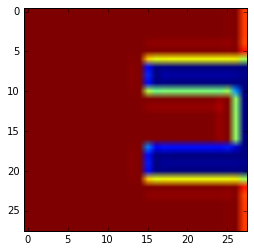

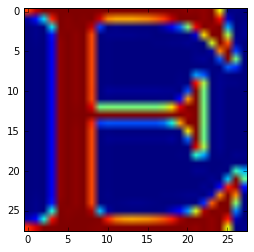

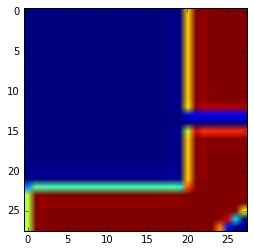

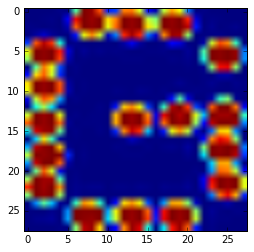

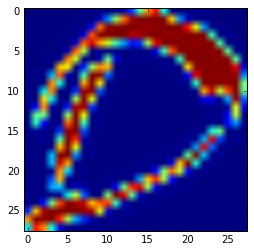

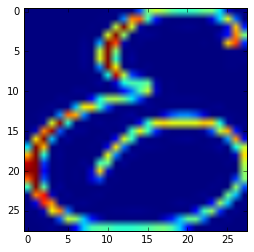

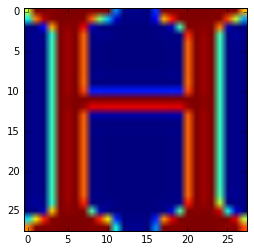

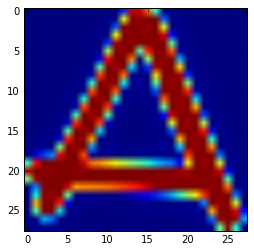

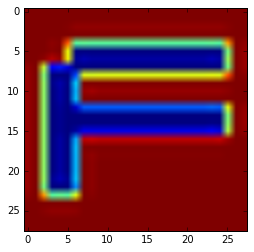

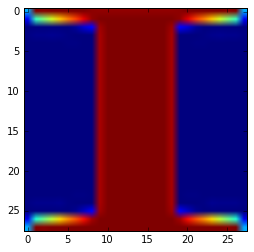

Test Examples => 10 of them


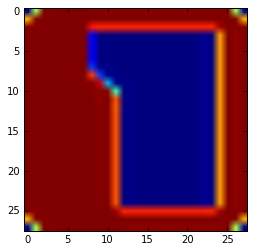

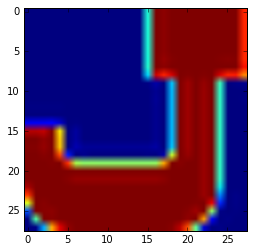

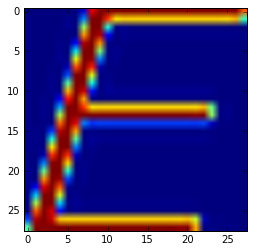

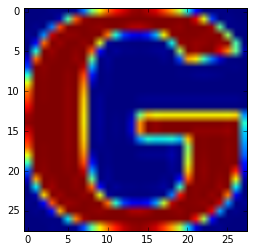

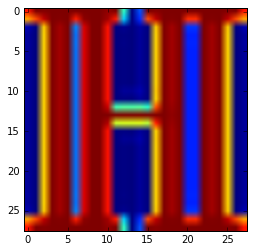

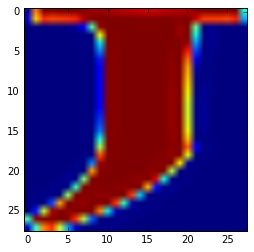

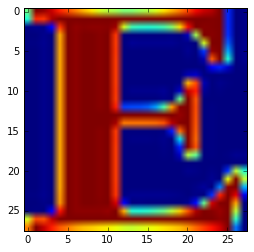

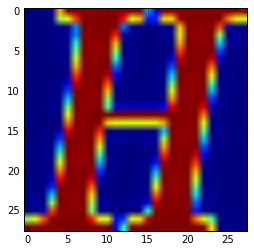

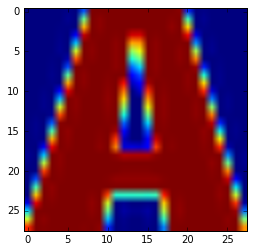

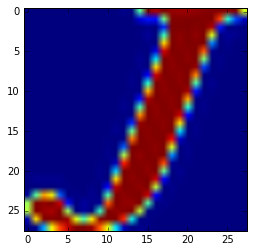

Valid Examples => 10 of them


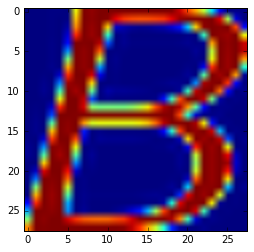

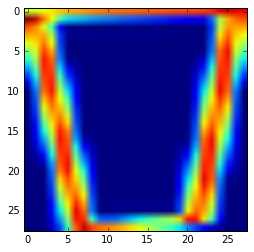

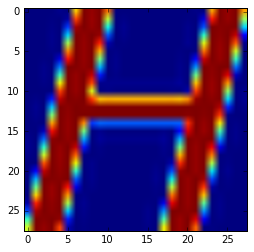

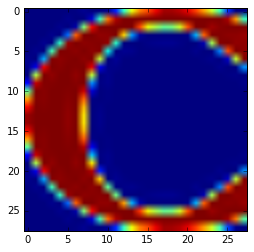

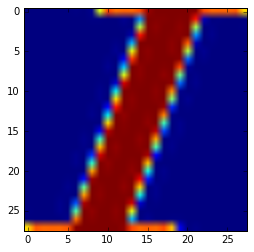

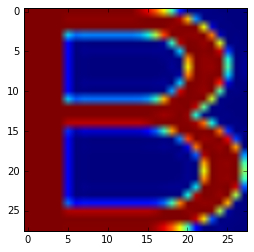

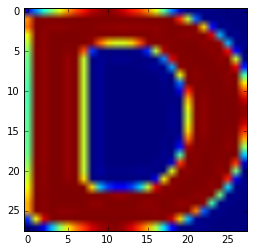

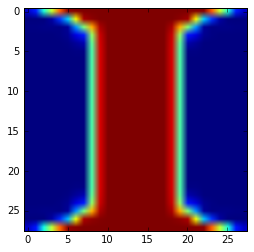

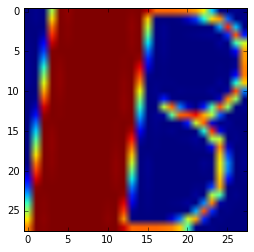

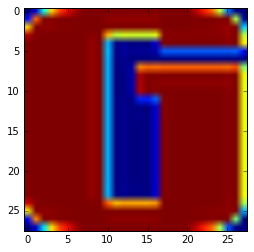

In [11]:
print("Train Examples => 10 of them")
for i in range(0, train_dataset.shape[0], 20000):
    display_pickle_image(image_arr=train_dataset[i])

print("Test Examples => 10 of them")
for i in range(0, test_dataset.shape[0], 1000):
    display_pickle_image(image_arr=test_dataset[i])

print("Valid Examples => 10 of them")
for i in range(0, valid_dataset.shape[0], 1000):
    display_pickle_image(image_arr=valid_dataset[i])

Finally, let's save the data for later reuse:

In [12]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [13]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [21]:
set_valid_dataset = set([hash(str(x)) for x in valid_dataset])
set_test_dataset = set([hash(str(x)) for x in test_dataset])
set_train_dataset = set([hash(str(x)) for x in train_dataset])

In [23]:
print('valid data set: ' + str(len(valid_dataset)) + ' set: ' + str(len(set_valid_dataset)))
print('test data set: ' + str(len(test_dataset)) + ' set: ' + str(len(set_test_dataset)))
print('train data set: ' + str(len(train_dataset)) + ' set: ' + str(len(set_train_dataset)))

valid data set: 10000 set: 9853
test data set: 10000 set: 9798
train data set: 200000 set: 187472


In [25]:
overlap_test_valid = set_test_dataset - set_valid_dataset
print('overlap test valid: ' + str(len(overlap_test_valid)))

overlap_train_valid = set_train_dataset - set_valid_dataset
print('overlap train valid: ' + str(len(overlap_train_valid)))

overlap_train_test = set_train_dataset - set_test_dataset
print('overlap train test: ' + str(len(overlap_train_test)))

overlap test valid: 9725
overlap train valid: 186508
overlap train test: 186342


This is not exactly correct due to the str python function
```python
>>> str(a)
'[0 0 0 ..., 0 0 0]'
```

In [26]:
from hashlib import md5
%time set_valid_dataset_2 = set([ md5(x).hexdigest() for x in valid_dataset])
%time set_test_dataset_2 = set([ md5(x).hexdigest() for x in test_dataset])
%time set_train_dataset_2 = set([ md5(x).hexdigest() for x in train_dataset])

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 59.5 ms
CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 56.6 ms
CPU times: user 1.4 s, sys: 0 ns, total: 1.4 s
Wall time: 1.4 s


In [27]:
overlap_test_valid_2 = set_test_dataset_2 - set_valid_dataset_2
print('overlap test valid: ' + str(len(overlap_test_valid_2)))

overlap_train_valid_2 = set_train_dataset_2 - set_valid_dataset_2
print('overlap train valid: ' + str(len(overlap_train_valid_2)))

overlap_train_test_2 = set_train_dataset_2 - set_test_dataset_2
print('overlap train test: ' + str(len(overlap_train_test_2)))

overlap test valid: 9725
overlap train valid: 186508
overlap train test: 186342


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [65]:
d = {}
try:
    with open(pickle_file, 'r') as f:
        d= pickle.load(f)
    locals().update(save)
except Exception as e:
    print(e)
print(d.keys())

print(len(train_dataset))

flat_train_dataset_50 = [x.flatten() for x in train_dataset[:50]]
flat_train_dataset_100 = [x.flatten() for x in train_dataset[:100]]
flat_train_dataset_1000 = [x.flatten() for x in train_dataset[:1000]]
flat_train_dataset_5000 = [x.flatten() for x in train_dataset[:5000]]

logregCV = LogisticRegressionCV()
model_50 = logregCV.fit(flat_train_dataset_50, train_labels[:50])
model_100 = logregCV.fit(flat_train_dataset_100, train_labels[:100])
model_1000 = logregCV.fit(flat_train_dataset_1000, train_labels[:1000])
model_5000 = logregCV.fit(flat_train_dataset_5000, train_labels[:5000])

score_50 = cross_val_score(model_50, flat_train_dataset_50, train_labels[:50]).mean()
score_100 = cross_val_score(model_100, flat_train_dataset_100, train_labels[:100]).mean()
score_1000 = cross_val_score(model_1000, flat_train_dataset_1000, train_labels[:1000]).mean()
score_5000 = cross_val_score(model_5000, flat_train_dataset_5000, train_labels[:5000]).mean()

print("Score50: "+str(score_50))
print("Score100: "+str(score_100))
print("Score1000: "+str(score_1000))
print("Score5000: "+str(score_5000))

['train_labels', 'valid_labels', 'test_labels', 'test_dataset', 'train_dataset', 'valid_dataset']
200000
Score50: 0.459678608285
Score100: 0.62299295263
Score1000: 0.768002153759
Score5000: 0.797397018038


Looks like the score_5000 is the best predictor, try it out on an image.
Pick a random start in the test dataset, and display prediction and image by stride

In [66]:
start_rand_idx = random.randrange(0, test_dataset.shape[0]-1)
print(start_rand_idx)

5216


Stride 100 start idx: 5216 test dataset size: 10000


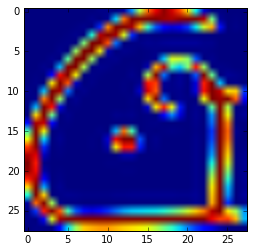

Predicted Label: notMNIST_large/A


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


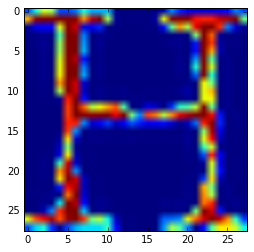

Predicted Label: notMNIST_large/H


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


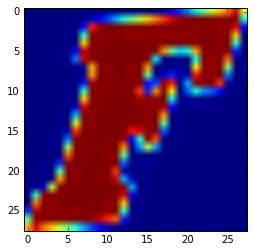

Predicted Label: notMNIST_large/F


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


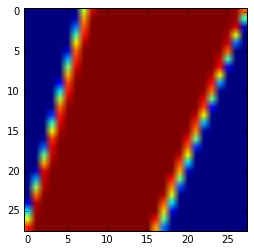

Predicted Label: notMNIST_large/I


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


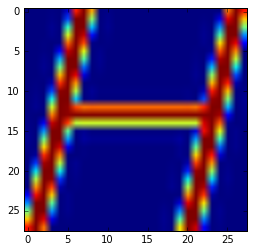

Predicted Label: notMNIST_large/H


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


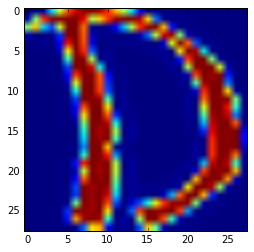

Predicted Label: notMNIST_large/D


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


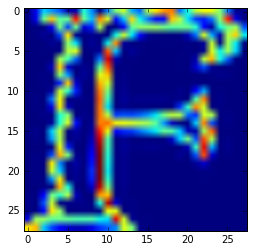

Predicted Label: notMNIST_large/F


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


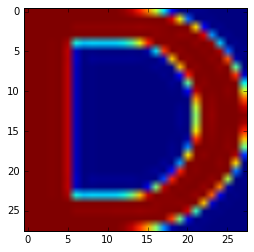

Predicted Label: notMNIST_large/D


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


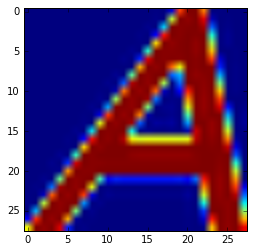

Predicted Label: notMNIST_large/A


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


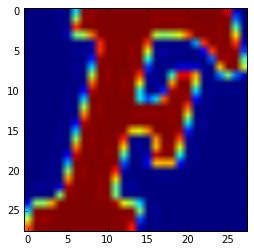

Predicted Label: notMNIST_large/F


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


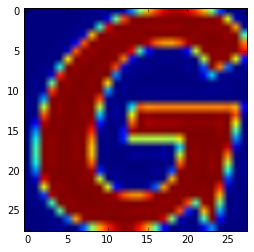

Predicted Label: notMNIST_large/G


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


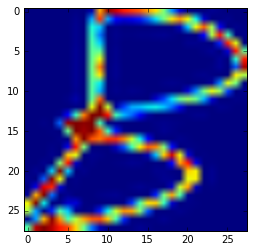

Predicted Label: notMNIST_large/F


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


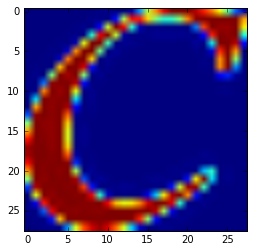

Predicted Label: notMNIST_large/C


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


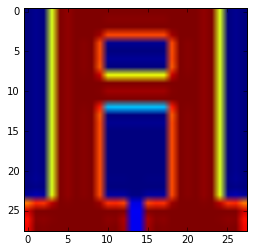

Predicted Label: notMNIST_large/A


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


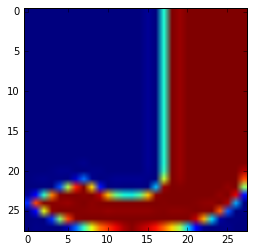

Predicted Label: notMNIST_large/J


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


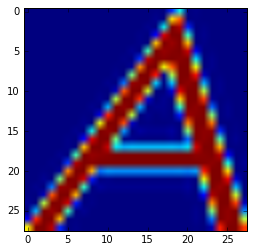

Predicted Label: notMNIST_large/A


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


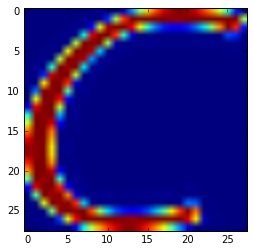

Predicted Label: notMNIST_large/C


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


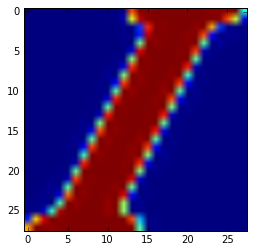

Predicted Label: notMNIST_large/I


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


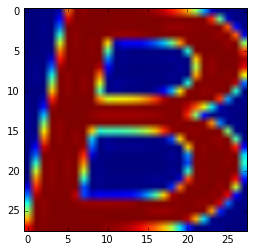

Predicted Label: notMNIST_large/B


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


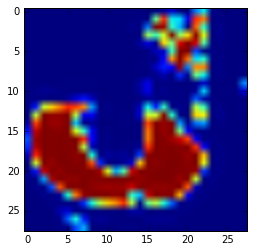

Predicted Label: notMNIST_large/J


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


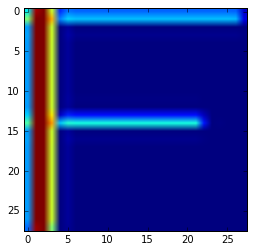

Predicted Label: notMNIST_large/F


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


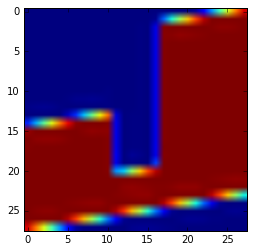

Predicted Label: notMNIST_large/J


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


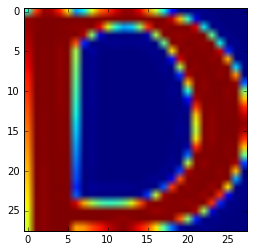

Predicted Label: notMNIST_large/D


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


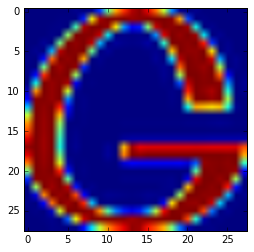

Predicted Label: notMNIST_large/C


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


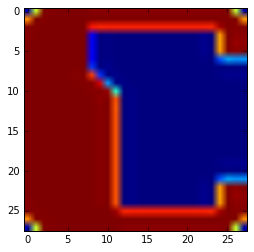

Predicted Label: notMNIST_large/E


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


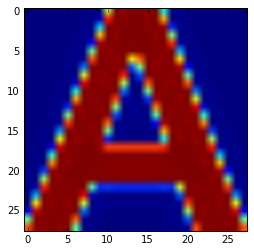

Predicted Label: notMNIST_large/A


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


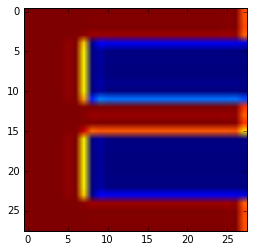

Predicted Label: notMNIST_large/E


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


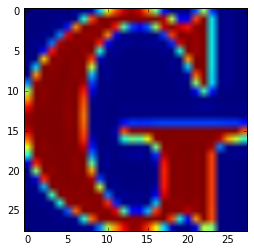

Predicted Label: notMNIST_large/G


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


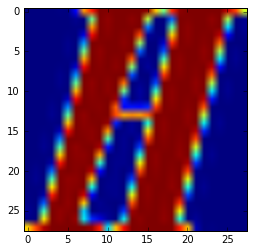

Predicted Label: notMNIST_large/J


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


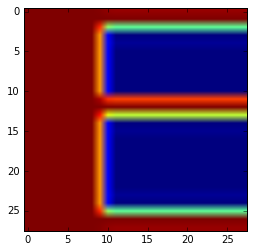

Predicted Label: notMNIST_large/E


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


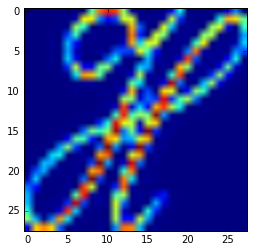

Predicted Label: notMNIST_large/F


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


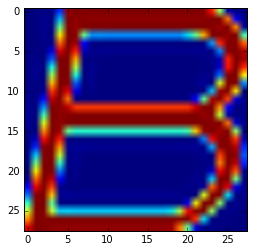

Predicted Label: notMNIST_large/B


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


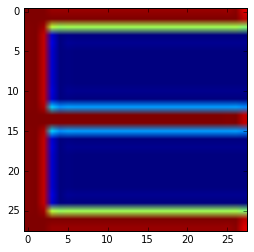

Predicted Label: notMNIST_large/E


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


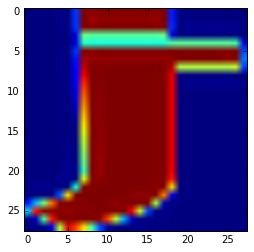

Predicted Label: notMNIST_large/I


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


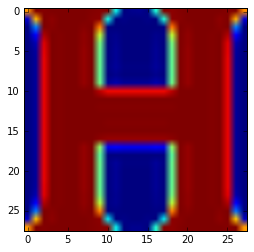

Predicted Label: notMNIST_large/H


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


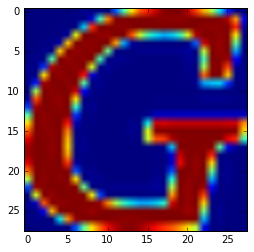

Predicted Label: notMNIST_large/G


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


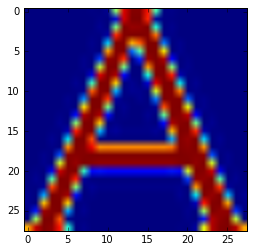

Predicted Label: notMNIST_large/A


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


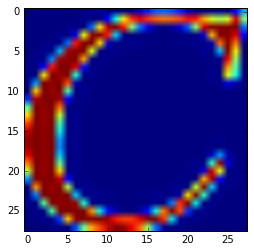

Predicted Label: notMNIST_large/C


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


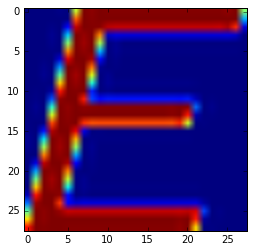

Predicted Label: notMNIST_large/E


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


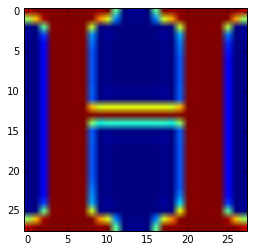

Predicted Label: notMNIST_large/H


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


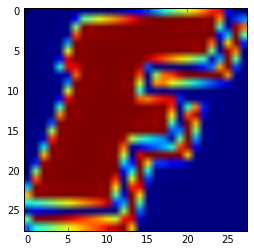

Predicted Label: notMNIST_large/F


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


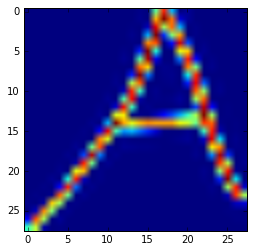

Predicted Label: notMNIST_large/A


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


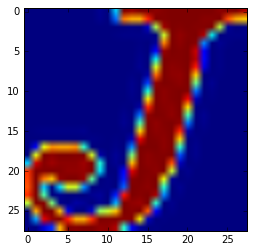

Predicted Label: notMNIST_large/J


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


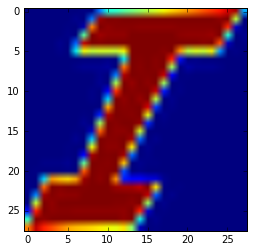

Predicted Label: notMNIST_large/I


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


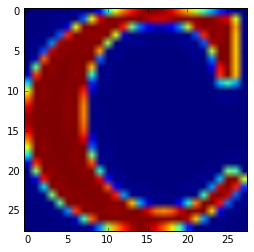

Predicted Label: notMNIST_large/C


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


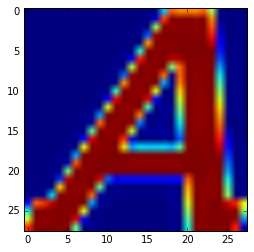

Predicted Label: notMNIST_large/A


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


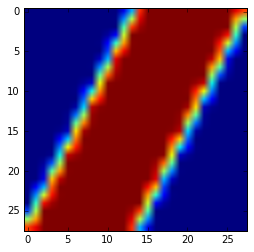

Predicted Label: notMNIST_large/I


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


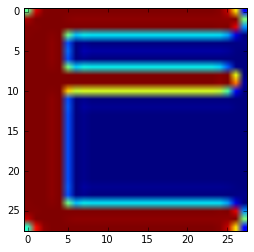

Predicted Label: notMNIST_large/C


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [67]:
stride=100
print("Stride "+str(stride)+" start idx: "+str(start_rand_idx)+" test dataset size: "+str(test_dataset.shape[0]))
for i in range(start_rand_idx, test_dataset.shape[0]-1, stride):
    display_pickle_image(image_arr=test_dataset[i])
    print("Predicted Label: "+str(train_folders[model_5000.predict(test_dataset[i].flatten())]))
